In [6]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

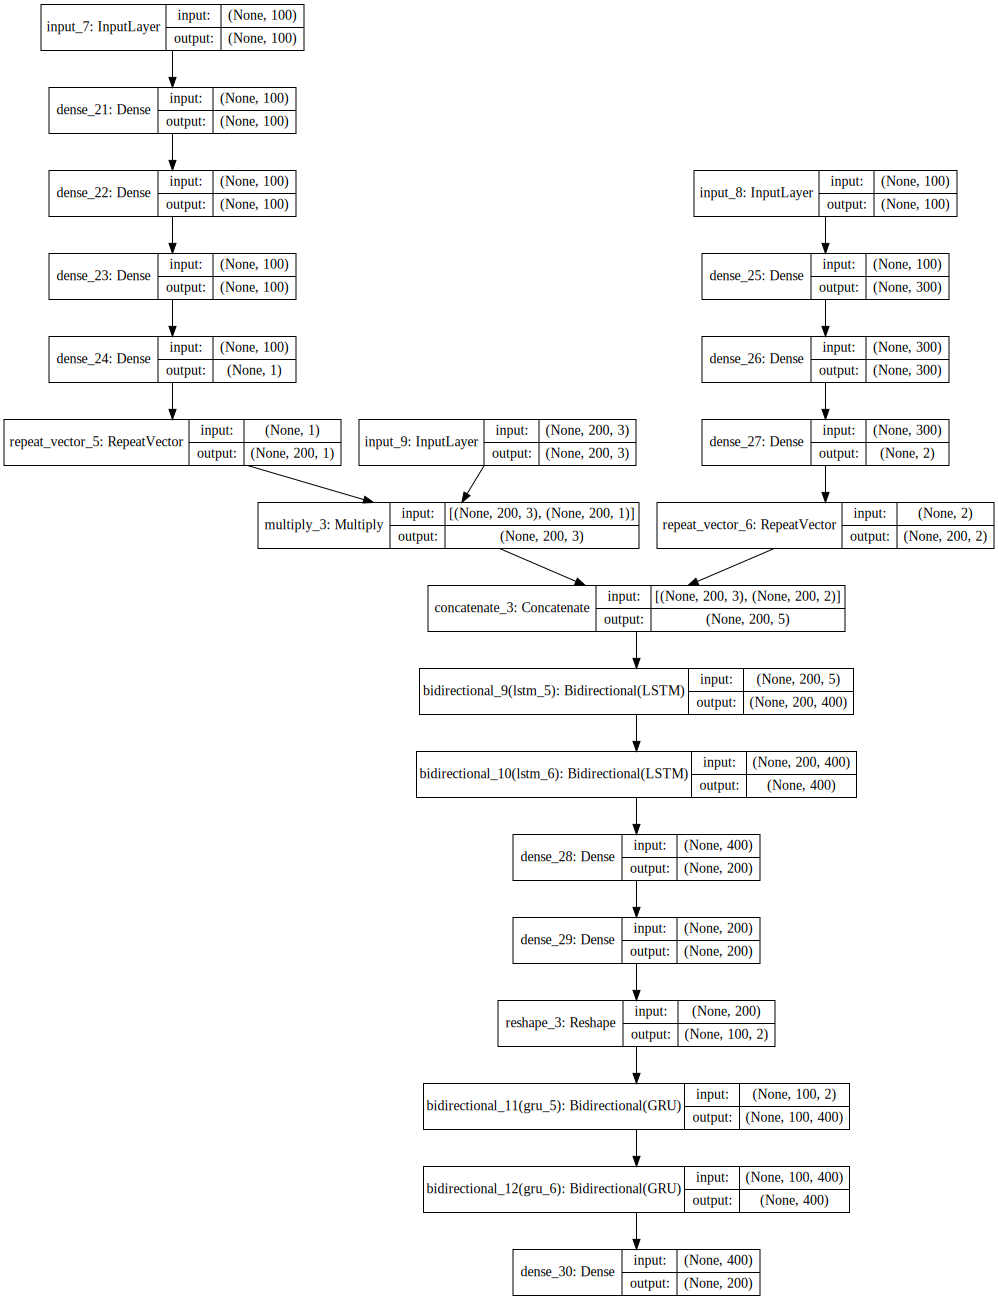

In [7]:
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import multiply
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Reshape
from keras.layers import GRU
def build_end_to_end_model_regression_larger_bidir_window(preamble_length, data_length, channel_length, output_length):
    preamble_cfo = Input(shape=(preamble_length * 2,))
    preamble_channel = Input(shape=(preamble_length * 2,))
    data = Input(shape=(data_length, 3))
    
    cfo_layer_1 = Dense(100, activation='tanh', use_bias=True)(preamble_cfo)
    cfo_layer_2 = Dense(100, activation='tanh', use_bias=True)(cfo_layer_1)
    cfo_layer_3 = Dense(100, activation='tanh', use_bias=True)(cfo_layer_2)
    cfo_layer_output = Dense(1, activation='linear', use_bias=True)(cfo_layer_3)
    cfo_layer_repeated = RepeatVector(data_length)(cfo_layer_output)
    
    data_transformed = multiply([data, cfo_layer_repeated])
    
    preamble_layer_1 = Dense(300, activation='relu')(preamble_channel)
    preamble_layer_2 = Dense(300, activation='relu')(preamble_layer_1)
    
    channel = Dense(channel_length, activation='sigmoid')(preamble_layer_2)
    
    channel_repeated = RepeatVector(data_length)(channel)
    
    output = concatenate([data_transformed, channel_repeated])
    data_layers = Bidirectional(LSTM(data_length, return_sequences=True))(output)
    data_layers_2 = Bidirectional(LSTM(data_length))(data_layers)
    
    output_1 = Dense(output_length, activation='relu')(data_layers_2)
    equalized_data = Dense(output_length, activation='linear')(output_1)
    
    reshaped_data = Reshape((output_length // 2, 2))(equalized_data)
    ecc_layer_1 = Bidirectional(GRU(200, return_sequences=True))(reshaped_data)
    ecc_layer_2 = Bidirectional(GRU(200))(ecc_layer_1)
    
    output = Dense(data_length, activation='linear')(ecc_layer_2)
    
    model = Model(inputs=[preamble_cfo, preamble_channel, data], outputs=[output])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

model = build_end_to_end_model_regression_larger_bidir_window(50, 200, 2, 200)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))